In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

datapath = "/content/gdrive/My Drive/Datasets/MNIST/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Library Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

from xgboost import XGBClassifier

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torch.nn.utils import weight_norm as WN
import torch.nn.functional as F

from time import time

import random as r

# Helper Functions

In [3]:
def breaker():
  print("\n" + 30*"-" + "\n")

def head(x, no_of_ele=5):
  breaker()
  print(x[:no_of_ele])
  breaker()

def getData():
  tr = pd.read_csv(datapath + "train.csv")
  ts = pd.read_csv(datapath + "test.csv")

  breaker()
  print("TRAINING SET")
  breaker()
  print(tr.head())
  print("\nTraining Set Shape :", repr(tr.shape))
  breaker()
  print("TEST SET")
  breaker()
  print(tr.head())
  print("\nTest Set Shape     :", repr(ts.shape))
  breaker()

  return tr, ts

# Data Handling

**Inputs** 

In [4]:
tr_Set, ts_Set = getData()

X, y = tr_Set.iloc[:, 1:].copy().values, tr_Set.iloc[:, 0].copy().values

X_test, y_test = ts_Set.iloc[:, 1:].copy().values, ts_Set.iloc[:, 0].copy().values

del tr_Set, ts_Set

num_features = X.shape[1]
num_obs_test = X_test.shape[0]


------------------------------

TRAINING SET

------------------------------

   label  1x1  1x2  1x3  1x4  1x5  ...  28x23  28x24  28x25  28x26  28x27  28x28
0      5    0    0    0    0    0  ...      0      0      0      0      0      0
1      0    0    0    0    0    0  ...      0      0      0      0      0      0
2      4    0    0    0    0    0  ...      0      0      0      0      0      0
3      1    0    0    0    0    0  ...      0      0      0      0      0      0
4      9    0    0    0    0    0  ...      0      0      0      0      0      0

[5 rows x 785 columns]

Training Set Shape : (60000, 785)

------------------------------

TEST SET

------------------------------

   label  1x1  1x2  1x3  1x4  1x5  ...  28x23  28x24  28x25  28x26  28x27  28x28
0      5    0    0    0    0    0  ...      0      0      0      0      0      0
1      0    0    0    0    0    0  ...      0      0      0      0      0      0
2      4    0    0    0    0    0  ...      0      0      

**Dataset Template**

In [5]:
class DS(Dataset):
  def __init__(this, X=None, y=None):
    this.X = X
    this.y = y
  
  def __len__(this):
    return this.X.shape[0]

  def __getitem__(this, idx):
    return torch.FloatTensor(this.X[idx]), torch.LongTensor(this.y[idx])

# XGBoost

In [6]:
#xgb = XGBClassifier(tree_method="gpu_hist")

#start_time = time()
#n_folds = 4
#n_ests = [i*100 for i in range(1, 11)]

#params = [{"n_estimators" : n_ests}]
#gscv = GridSearchCV(estimator=xgb, param_grid=params, scoring="accuracy", cv=n_folds)
#gscv.fit(X, y)

#breaker()
#print("Time Taken for {n} Fold CV for {num} different estimator values : {:.2f} seconds".format((time()-start_time), n=n_folds, num = len(n_ests)))
#breaker()
#print(gscv.best_params_)
#breaker()
#print("Accuracy of XGB Model: %.2f" % (accuracy_score(y_test, gscv.predict(X_test))))
#breaker()"""

# 2760.43 seconds runtime, n_estimators = 1000, accuracy = 0.98

In [7]:
start_time = time()

xgb = XGBClassifier(n_estimators = 1000, tree_method="gpu_hist", random_state=0)
xgb.fit(X, y)
y_pred = xgb.predict(X_test)

breaker()
print("Time taken to Train : %.2f minutes" % ((time()-start_time)/60))
breaker()
print("XGB Model Accuracy  : {:.5f} %".format(accuracy_score(y_test, y_pred) * 100))
breaker()

del start_time, xgb, y_pred


------------------------------

Time taken to Train : 2.36 minutes

------------------------------

XGB Model Accuracy  : 97.76000 %

------------------------------



# Artifical Neural Network

**Config**

In [8]:
class ANN_CFG():
  tr_batch_size = 128
  va_batch_size = 128
  ts_batch_size = 256

  epochs = 20
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  IL = num_features
  OL = 10

cfg = ANN_CFG()

**Setup**

In [9]:
class ANN(nn.Module):
  def __init__(this, IL=None, HL=None, OL=None):
    super(ANN, this).__init__()

    this.BN = nn.BatchNorm1d(IL)
    this.FC = WN(nn.Linear(IL, OL))
  
  def forward(this, x):
    x = this.BN(x)
    x = F.log_softmax(this.FC(x), dim=1)
    return x

  def getOptimizer(this):
    return optim.Adam(this.parameters(), lr=1e-3)

breaker()
print("Train Batch Size :", repr(cfg.tr_batch_size))
print("Valid Batch Size :", repr(cfg.va_batch_size))
print("Test Batch Size  :", repr(cfg.ts_batch_size))
print("Device Used      :", cfg.device)
breaker()


------------------------------

Train Batch Size : 128
Valid Batch Size : 128
Test Batch Size  : 256
Device Used      : cuda:0

------------------------------



**Helper Functions**

In [10]:
def train_fn(X=None, y=None):
  bestLoss = {"train" : np.inf, "valid" : np.inf}
  LP = []
  name_getter = []
  n_folds = 4
  fold = 0

  start_time = time()

  for tr_idx, va_idx in StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=0).split(X, y):
    breaker()
    print("Fold {fold}".format(fold=fold+1))

    X_train, X_valid, y_train, y_valid = X[tr_idx], X[va_idx], y[tr_idx], y[va_idx]

    tr_data_setup = DS(X_train, y_train.reshape(-1,1))
    va_data_setup = DS(X_valid, y_valid.reshape(-1,1))

    dataloaders = {"train" : DL(tr_data_setup, batch_size=cfg.tr_batch_size, shuffle=True, generator=torch.manual_seed(0)),
                   "valid" : DL(va_data_setup, batch_size=cfg.va_batch_size, shuffle=False)}

    model = ANN(IL=cfg.IL, HL=None, OL=cfg.OL)
    model.to(cfg.device)

    optimizer = model.getOptimizer()

    for e in range(cfg.epochs):
      epochLoss = {"train" : 0, "valid" : 0}
      for phase in ["train", "valid"]:
        if phase == "train":
          model.train()
        else:
          model.eval()
        lossPerPass = 0

        for feats, label in dataloaders[phase]:
          feats, label = feats.to(cfg.device), label.to(cfg.device)

          with torch.set_grad_enabled(phase == "train"):
            output = model(feats)
            loss = nn.NLLLoss()(output, label.view(-1))
            if phase == "train":
              loss.backward()
              optimizer.step() 
          lossPerPass += (loss.item()/label.shape[0])
        epochLoss[phase] = lossPerPass
      LP.append(epochLoss)
      if epochLoss["valid"] < bestLoss["valid"]:
        bestLoss = epochLoss
        name = "Model_Fold_{fold}.pt".format(fold=fold)
        name_getter.append(name)
        torch.save(model.state_dict(), datapath+name)
    fold += 1

  breaker()
  print("Time taken to train for ({fold} folds, {e} epochs) = {:.2f} minutes".format(float((time() - start_time)/60), fold=n_folds, e=cfg.epochs))
  breaker()
  print("Best Loss :", repr(bestLoss))
  breaker()
  return LP, name_getter, model

def eval_fn(model=None, names=None, dataloader=None):
  final_Pred = np.zeros((num_obs_test, 1))

  for name in names:
    model.load_state_dict(torch.load(datapath+name))
    model.eval()
    Preds = torch.zeros(cfg.ts_batch_size, 1).to(cfg.device)
    for X, y in dataloader:
      X = X.to(cfg.device)
      with torch.no_grad():
        logProb = model(X)
      Prob = torch.exp(logProb)
      Pred = torch.argmax(Prob, dim=1)
      Preds = torch.cat((Preds, Pred.view(-1,1)), dim=0)
    Preds = Preds[cfg.ts_batch_size:].cpu().numpy()
    final_Pred = np.add(final_Pred, Preds)
  final_Pred = np.divide(final_Pred, len(names))
  return Preds.reshape(-1)

**Training**

In [11]:
LP, Names, Network = train_fn(X, y)

LPV = []
LPT = []
for i in range(len(LP)):
  LPT.append(LP[i]["train"])
  LPV.append(LP[i]["valid"])


------------------------------

Fold 1

------------------------------

Fold 2

------------------------------

Fold 3

------------------------------

Fold 4

------------------------------

Time taken to train for (4 folds, 20 epochs) = 2.07 minutes

------------------------------

Best Loss : {'train': 1.4873249370268442, 'valid': 0.8540075222263113}

------------------------------



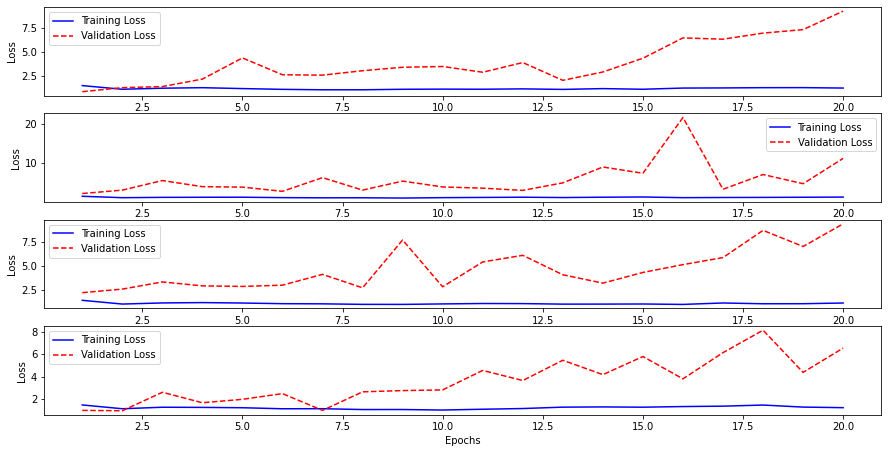

In [12]:
xAxis = [i+1 for i in range(cfg.epochs)]

plt.figure(figsize=(15, 7.5))
plt.subplot(4, 1, 1)
plt.plot(xAxis, LPT[:cfg.epochs], "b", label="Training Loss")
plt.plot(xAxis, LPV[:cfg.epochs], "r--", label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.subplot(4, 1, 2)
plt.plot(xAxis, LPT[1*cfg.epochs:2*cfg.epochs], "b", label="Training Loss")
plt.plot(xAxis, LPV[1*cfg.epochs:2*cfg.epochs], "r--", label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.subplot(4, 1, 3)
plt.plot(xAxis, LPT[2*cfg.epochs:3*cfg.epochs], "b", label="Training Loss")
plt.plot(xAxis, LPV[2*cfg.epochs:3*cfg.epochs], "r--", label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.subplot(4, 1, 4)
plt.plot(xAxis, LPT[3*cfg.epochs:4*cfg.epochs], "b", label="Training Loss")
plt.plot(xAxis, LPV[3*cfg.epochs:4*cfg.epochs], "r--", label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

**Evaluation on Test Set**

In [13]:
ts_data_setup = DS(X_test, y_test.reshape(-1,1))
ts_data = DL(ts_data_setup, batch_size=cfg.ts_batch_size, shuffle=False)

y_pred = eval_fn(Network, Names, ts_data)

breaker()
print("ANN Model Accuracy  : {:.5f} %".format(accuracy_score(y_test, y_pred) * 100))
breaker()


------------------------------

ANN Model Accuracy  : 88.99000 %

------------------------------

